In [14]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ttest_rel, binomtest

# ---------- files ----------
CONCAT_FILE = "10_fold_conc_embeddings_expression.csv"  # your concatenated embeddings result
BULK_FILE   = "voom_bulk_10_fold_30_pcs_tissue_growth.csv"

# pick your current *single-cell* baseline file here:
SC_BASELINE_FILE = "scfoundation_10_fold_embeddings_30_pcs_tissue_growth.csv"
# e.g., could also be: "scgpt_10_fold_embeddings_30_pcs_tissue_growth.csv"
# or your best pseudobulk scran baseline.

PATHS = {
    "ElasticNet": {
        "concat":     f"01_simple_baselines/results/elastic_net/{CONCAT_FILE}",
        "sc_base":    f"01_simple_baselines/results/elastic_net/{SC_BASELINE_FILE}",
        "bulk_pre":   f"01_simple_baselines/results/elastic_net/{BULK_FILE}",
    },
}

def load_one(path, model, tag):
    df = pd.read_csv(path)
    df["Model"] = model
    df["Dataset"] = tag
    # normalize metric names
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)
    if "r2_mean" not in df.columns and "r2_global" in df.columns:
        df = df.rename(columns={"r2_global":"r2_mean", "rmse":"rmse_mean"})
    need = {"DRUG_ID","n_samples","r2_mean","rmse_mean"}
    if not need.issubset(df.columns):
        missing = list(need - set(df.columns))
        raise ValueError(f"Missing columns in {path}: {missing}")
    keep = ["DRUG_ID","n_samples","r2_mean","rmse_mean","Model","Dataset"]
    if "pearson_r" in df.columns: keep += ["pearson_r"]
    if "pearson_pval" in df.columns: keep += ["pearson_pval"]
    return df[keep]

frames = []
for model, dct in PATHS.items():
    for tag, path in dct.items():
        frames.append(load_one(path, model, tag))
df_all = pd.concat(frames, ignore_index=True)
print("✅ combined:", df_all.shape)
df_all.head()


✅ combined: (1875, 8)


,DRUG_ID,n_samples,r2_mean,rmse_mean,Model,Dataset,pearson_r,pearson_pval
0,133,132,0.101780,1.605814,ElasticNet,concat,0.329242,0.000116
1,134,132,0.123006,1.790912,ElasticNet,concat,0.354862,0.000030
2,135,131,0.078936,2.505049,ElasticNet,concat,0.284279,0.000999
3,136,133,0.073512,1.450430,ElasticNet,concat,0.272061,0.001535
4,140,133,0.011403,1.628979,ElasticNet,concat,0.142982,0.100625


In [15]:
# %%
pretty_model   = {"ElasticNet":"Elastic Net","RandomForest":"Random Forest"}
pretty_dataset = {
    "concat":   "Concat (embeddings + expression)",
    "sc_base":  "Best single-cell baseline",
    "bulk_pre": "Bulk baseline",
}
df_plot = df_all.copy()
df_plot["ModelPretty"]   = df_plot["Model"].map(pretty_model)
df_plot["DatasetPretty"] = df_plot["Dataset"].map(pretty_dataset)


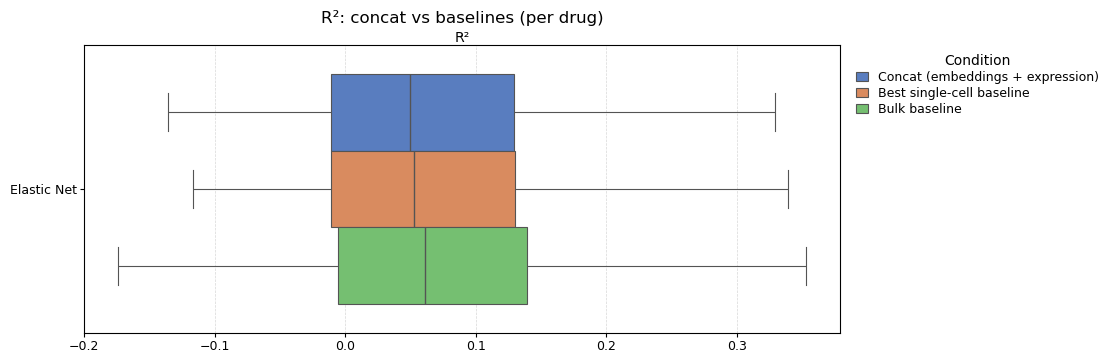

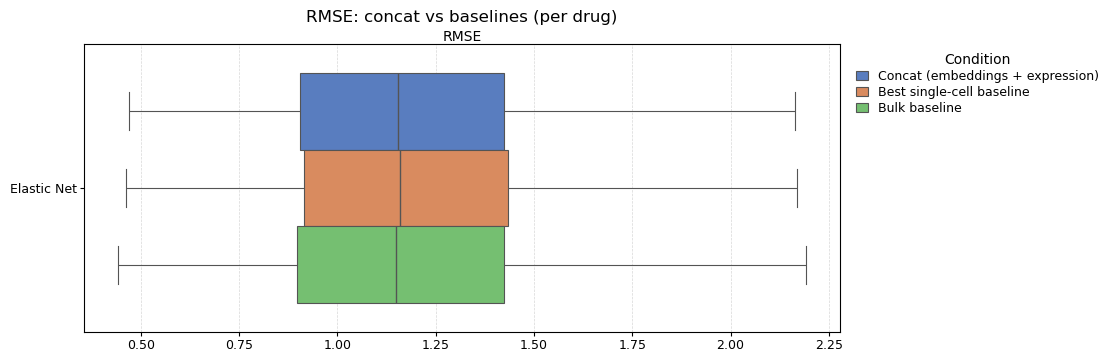

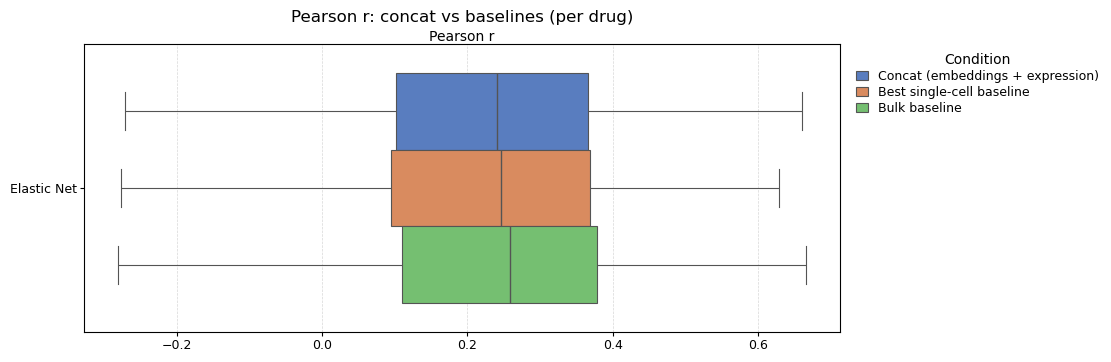

In [16]:
# %% compact boxplot helper (thin lines, top x-label, slim legend)
def nice_boxplot(df, x_metric, title):
    fig, ax = plt.subplots(figsize=(9, 3.6))
    sns.boxplot(
        data=df, x=x_metric, y="ModelPretty",
        hue="DatasetPretty", palette="muted",
        showfliers=False, dodge=True, ax=ax,
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
        medianprops=dict(linewidth=1.0),
    )
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel({"r2_mean":"R²","rmse_mean":"RMSE","pearson_r":"Pearson r"}.get(x_metric, x_metric),
                  fontsize=10, labelpad=2)
    ax.set_ylabel("")
    ax.legend(title="Condition", frameon=False, loc="upper left",
              bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10,
              handlelength=0.9, borderpad=0.2, labelspacing=0.25)
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
    plt.subplots_adjust(left=0.14, right=0.98, top=0.88, bottom=0.08)
    plt.show()

nice_boxplot(df_plot, "r2_mean",   "R²: concat vs baselines (per drug)")
nice_boxplot(df_plot, "rmse_mean", "RMSE: concat vs baselines (per drug)")
if "pearson_r" in df_plot.columns:
    nice_boxplot(df_plot, "pearson_r", "Pearson r: concat vs baselines (per drug)")


In [17]:
# %% paired deltas vs each baseline (per model) — positive => concat better
def paired_vs_tag(df, model, metric, compare_tag="concat", baseline_tag="sc_base"):
    sub = df[df["Model"] == model]
    wide = sub.pivot_table(index="DRUG_ID", columns="Dataset", values=metric, aggfunc="mean")
    if not ({compare_tag, baseline_tag} <= set(wide.columns)): return None
    pair = wide[[compare_tag, baseline_tag]].dropna()
    if pair.empty: return None
    x, y = pair[compare_tag], pair[baseline_tag]
    d = (x - y) if metric in ("r2_mean","pearson_r") else (y - x)  # positive => compare better
    n = len(d)
    return {
        "Model": model, "Metric": metric, "Compare": pretty_dataset[compare_tag], "Baseline": pretty_dataset[baseline_tag],
        "n": n, "delta_mean": d.mean(), "delta_median": d.median(), "win_rate": (d>0).mean(),
        "wilcoxon_p": wilcoxon(d, zero_method="pratt").pvalue if n>=5 else np.nan,
        "ttest_p": ttest_rel(x, y, nan_policy="omit").pvalue if n>=5 else np.nan
    }

rows = []
for m in ["ElasticNet","RandomForest"]:
    for met in ["r2_mean","rmse_mean","pearson_r"]:
        if met not in df_plot.columns: continue
        for base in ["sc_base","bulk_pre"]:
            out = paired_vs_tag(df_all, m, met, compare_tag="concat", baseline_tag=base)
            if out: rows.append(out)
paired_summary = pd.DataFrame(rows)
display(paired_summary)


,Model,Metric,Compare,Baseline,n,delta_mean,delta_median,win_rate,wilcoxon_p,ttest_p
0,ElasticNet,r2_mean,Concat (embeddings + expression),Best single-cell baseline,625,-0.001441,-0.004173,0.4512,0.107359,0.397606
1,ElasticNet,r2_mean,Concat (embeddings + expression),Bulk baseline,625,-0.008751,-0.006712,0.4528,0.000368,0.000764
2,ElasticNet,rmse_mean,Concat (embeddings + expression),Best single-cell baseline,625,-0.000370,-0.002119,0.4512,0.154718,0.761855
3,ElasticNet,rmse_mean,Concat (embeddings + expression),Bulk baseline,625,-0.003574,-0.003692,0.4512,0.004040,0.047120
4,ElasticNet,pearson_r,Concat (embeddings + expression),Best single-cell baseline,625,-0.000330,-0.005963,0.4544,0.209481,0.915389
5,ElasticNet,pearson_r,Concat (embeddings + expression),Bulk baseline,625,-0.011096,-0.011710,0.4560,0.004568,0.027695


In [18]:
# %% aggregate stats per Model x Dataset (means/SD/95% CI)
def agg_stats(df, metric):
    g = (df.groupby(["ModelPretty","DatasetPretty"], as_index=False)[metric]
           .agg(mean="mean", std="std", n="count"))
    g["se"]   = g["std"] / np.sqrt(g["n"])
    g["ci95"] = 1.96 * g["se"]
    g["metric"] = metric
    return g.rename(columns={"mean":"Mean","std":"Std","n":"N","ci95":"95% CI"})

tables = []
for met in ["r2_mean","rmse_mean","pearson_r"]:
    if met in df_plot.columns: tables.append(agg_stats(df_plot, met))
summary_table = pd.concat(tables, ignore_index=True)
display(summary_table[["metric","ModelPretty","DatasetPretty","N","Mean","Std","95% CI"]].round(4))


,metric,ModelPretty,DatasetPretty,N,Mean,Std,95% CI
0,r2_mean,Elastic Net,Best single-cell baseline,625,0.0703,0.1018,0.0080
1,r2_mean,Elastic Net,Bulk baseline,625,0.0776,0.1060,0.0083
2,r2_mean,Elastic Net,Concat (embeddings + expression),625,0.0688,0.1027,0.0081
3,rmse_mean,Elastic Net,Best single-cell baseline,625,1.1879,0.3738,0.0293
4,rmse_mean,Elastic Net,Bulk baseline,625,1.1847,0.3787,0.0297
5,rmse_mean,Elastic Net,Concat (embeddings + expression),625,1.1883,0.3735,0.0293
6,pearson_r,Elastic Net,Best single-cell baseline,625,0.2249,0.1987,0.0156
7,pearson_r,Elastic Net,Bulk baseline,625,0.2356,0.2035,0.0160
8,pearson_r,Elastic Net,Concat (embeddings + expression),625,0.2245,0.1972,0.0155


In [19]:
# %% per-drug win counts vs each baseline + sign tests
def wins_vs_tag(df, model, metric, compare_tag, baseline_tag, tie_tol):
    sub = df[df["Model"] == model]
    wide = sub.pivot_table(index="DRUG_ID", columns="Dataset", values=metric, aggfunc="mean")
    if not ({compare_tag, baseline_tag} <= set(wide.columns)): return None
    pair = wide[[compare_tag, baseline_tag]].dropna()
    if pair.empty: return None
    if metric in ("r2_mean","pearson_r"):
        d = pair[compare_tag] - pair[baseline_tag]     # positive => compare better
    else:
        d = pair[baseline_tag] - pair[compare_tag]     # positive => compare better (lower RMSE)
    winners = np.where(d >  tie_tol, compare_tag,
               np.where(d < -tie_tol, baseline_tag, "Tie"))
    n_non_ties = int((winners != "Tie").sum())
    n_comp     = int((winners == compare_tag).sum())
    p = binomtest(n_comp, n_non_ties, 0.5, alternative="two-sided").pvalue if n_non_ties>0 else np.nan
    return {
        "Model": model, "Metric": metric, "Compare": pretty_dataset[compare_tag], "Baseline": pretty_dataset[baseline_tag],
        "Compare wins": n_comp, "Baseline wins": int((winners==baseline_tag).sum()),
        "Ties": int((winners=="Tie").sum()),
        "Compare win rate (no ties)": n_comp / n_non_ties if n_non_ties else np.nan,
        "Sign test p": p
    }

rows = []
for m in ["ElasticNet","RandomForest"]:
    for met, tol in [("r2_mean",0.002), ("rmse_mean",0.005), ("pearson_r",0.01)]:
        if met not in df_all.columns: continue
        for base in ["sc_base","bulk_pre"]:
            out = wins_vs_tag(df_all, m, met, "concat", base, tol)
            if out: rows.append(out)
wins_table = pd.DataFrame(rows)
display(wins_table)


,Model,Metric,Compare,Baseline,Compare wins,Baseline wins,Ties,Compare win rate (no ties),Sign test p
0,ElasticNet,r2_mean,Concat (embeddings + expression),Best single-cell baseline,270,322,33,0.456081,0.035986
1,ElasticNet,r2_mean,Concat (embeddings + expression),Bulk baseline,270,336,19,0.445545,0.008227
2,ElasticNet,rmse_mean,Concat (embeddings + expression),Best single-cell baseline,221,277,127,0.443775,0.013636
3,ElasticNet,rmse_mean,Concat (embeddings + expression),Bulk baseline,237,302,86,0.439703,0.005789
4,ElasticNet,pearson_r,Concat (embeddings + expression),Best single-cell baseline,249,295,81,0.457721,0.053586
5,ElasticNet,pearson_r,Concat (embeddings + expression),Bulk baseline,258,320,47,0.446367,0.011109


/tmp/ipykernel_2055374/788697894.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


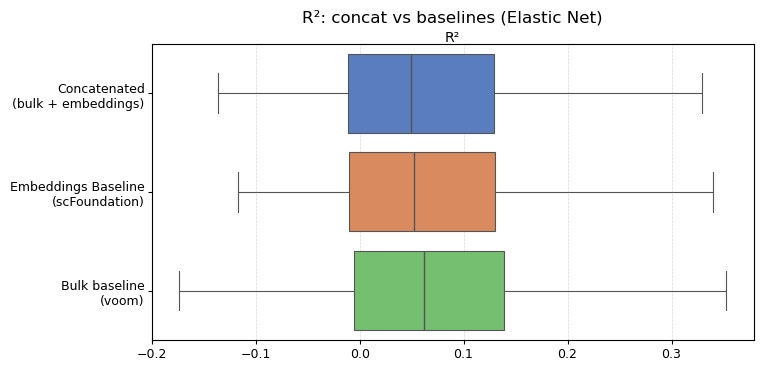

/tmp/ipykernel_2055374/788697894.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


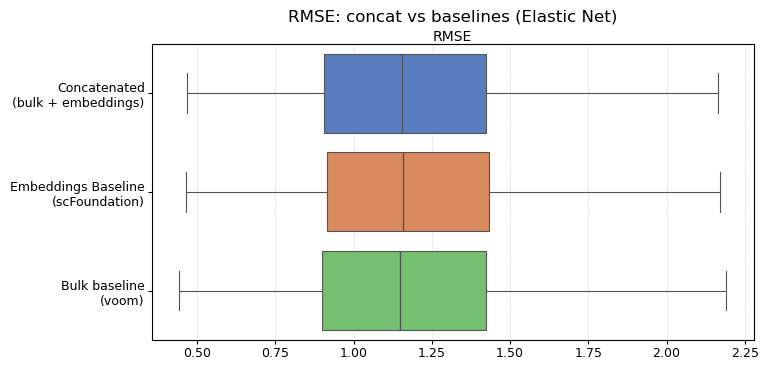

/tmp/ipykernel_2055374/788697894.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


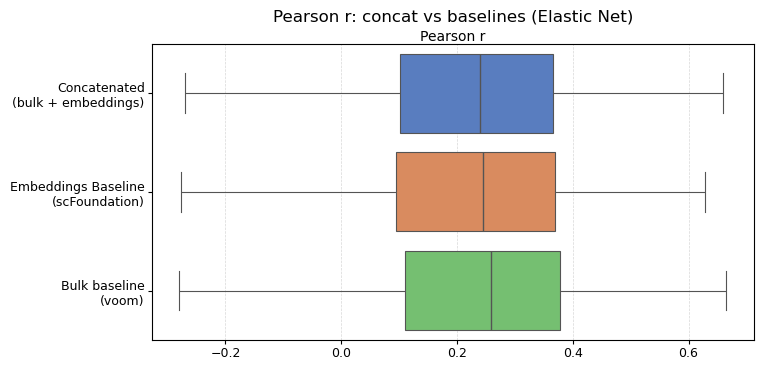

In [24]:
# %% Concatenated embeddings — SEPARATE distribution plots (Elastic Net only) with custom y-labels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Expect a dataframe with the three conditions for Elastic Net in either df_plot, df_all, or df
src = None
for cand in ["df_plot", "df_all", "df"]:
    if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
        src = globals()[cand].copy()
        break
if src is None:
    raise ValueError("Please define df_plot / df_all / df with concatenation results.")

# Keep Elastic Net only (if Model column exists)
if "Model" in src.columns:
    src = src[src["Model"].isin(["ElasticNet", "Elastic Net"])].copy()

# ---- Custom display names (with newlines) ----
NAME_CONCAT = "Concatenated\n(bulk + embeddings)"
NAME_SCBASE = "Embeddings Baseline\n(scFoundation)"
NAME_BULK   = "Bulk baseline\n(voom)"

def _infer_cond(s):
    s = str(s).lower()
    if "concat" in s:  return NAME_CONCAT
    if "bulk" in s:    return NAME_BULK
    # treat anything else that was your single-cell best as scFoundation baseline
    if "sc_base" in s or "single" in s or "best" in s or "scfoundation" in s or "embedding" in s:
        return NAME_SCBASE
    return s

# Build clean condition label
if "DatasetPretty" in src.columns:
    # map known pretty names to the custom ones
    src["CondPretty"] = src["DatasetPretty"].map({
        "Concat (embeddings + expression)": NAME_CONCAT,
        "Best single-cell baseline": NAME_SCBASE,
        "Bulk baseline": NAME_BULK,
    }).fillna(src["DatasetPretty"].map(_infer_cond))
elif "Dataset" in src.columns:
    src["CondPretty"] = src["Dataset"].map(_infer_cond)
else:
    raise ValueError("Need 'DatasetPretty' or 'Dataset' to identify the three conditions.")

# Consistent order on the y-axis (top to bottom)
order = [NAME_CONCAT, NAME_SCBASE, NAME_BULK]
src["CondPretty"] = pd.Categorical(src["CondPretty"], categories=order, ordered=True)

# Find Spearman column if present
rho_col = next((c for c in ["spearman_r", "spearman_rho", "spearman"] if c in src.columns), None)

def single_box(x, title, xlabel, outfile):
    fig, ax = plt.subplots(figsize=(8.6, 3.8))
    sns.boxplot(
        data=src, x=x, y="CondPretty",
        showfliers=False, dodge=False, palette="muted", ax=ax,
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
        medianprops=dict(linewidth=1.0),
    )
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(xlabel, fontsize=10, labelpad=2)
    ax.set_ylabel("")
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
    # widen left margin to fit multi-line y labels
    plt.subplots_adjust(left=0.28, right=0.98, top=0.88, bottom=0.10)
    if outfile:
        Path(outfile).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(outfile, dpi=200, bbox_inches="tight")
    plt.show()

# --- export figures ---
single_box("r2_mean",   "R²: concat vs baselines (Elastic Net)",      "R²",         "Images/concat_r2.png")
single_box("rmse_mean", "RMSE: concat vs baselines (Elastic Net)",    "RMSE",       "Images/concat_rmse.png")
if "pearson_r" in src.columns:
    single_box("pearson_r", "Pearson r: concat vs baselines (Elastic Net)", "Pearson r", "Images/concat_pearsonr.png")
if rho_col is not None:
    single_box(rho_col, "Spearman ρ: concat vs baselines (Elastic Net)", "Spearman ρ",  "Images/concat_spearman.png")
